**Synthetic Minority Over-sampling Technique (SMOTE):**
- **Process**: Creates new samples by interpolating between minority instances and their nearest neighbors.
- **Benefit**: Avoids overfitting by generating unique, similar instances.
- **Limitation**: Can introduce noise if there are outliers in the minority class.

**Adaptive Synthetic Sampling (ADASYN):**
- **Process**: Allocates more synthetic samples to instances near the decision boundary. Focuses on generating more samples for difficult-to-classify minority instances.
- **Benefit**: Improves model performance by targeting hard-to-classify points.
- **Limitation**: More computationally expensive and may increase variance.

In [1]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from matplotlib.animation import (
        FuncAnimation, PillowWriter
    )
from matplotlib.colors import ListedColormap

plt.style.use('dark_background')

X, y = make_moons(
    n_samples=1000, noise=0.4, random_state=47
)

# Creating class-imbalance
X = np.vstack((X[y == 0][:500, :], X[y == 1][:50, :]))
y = np.hstack((y[y == 0][:500], y[y == 1][:50]))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=47, stratify=y
)

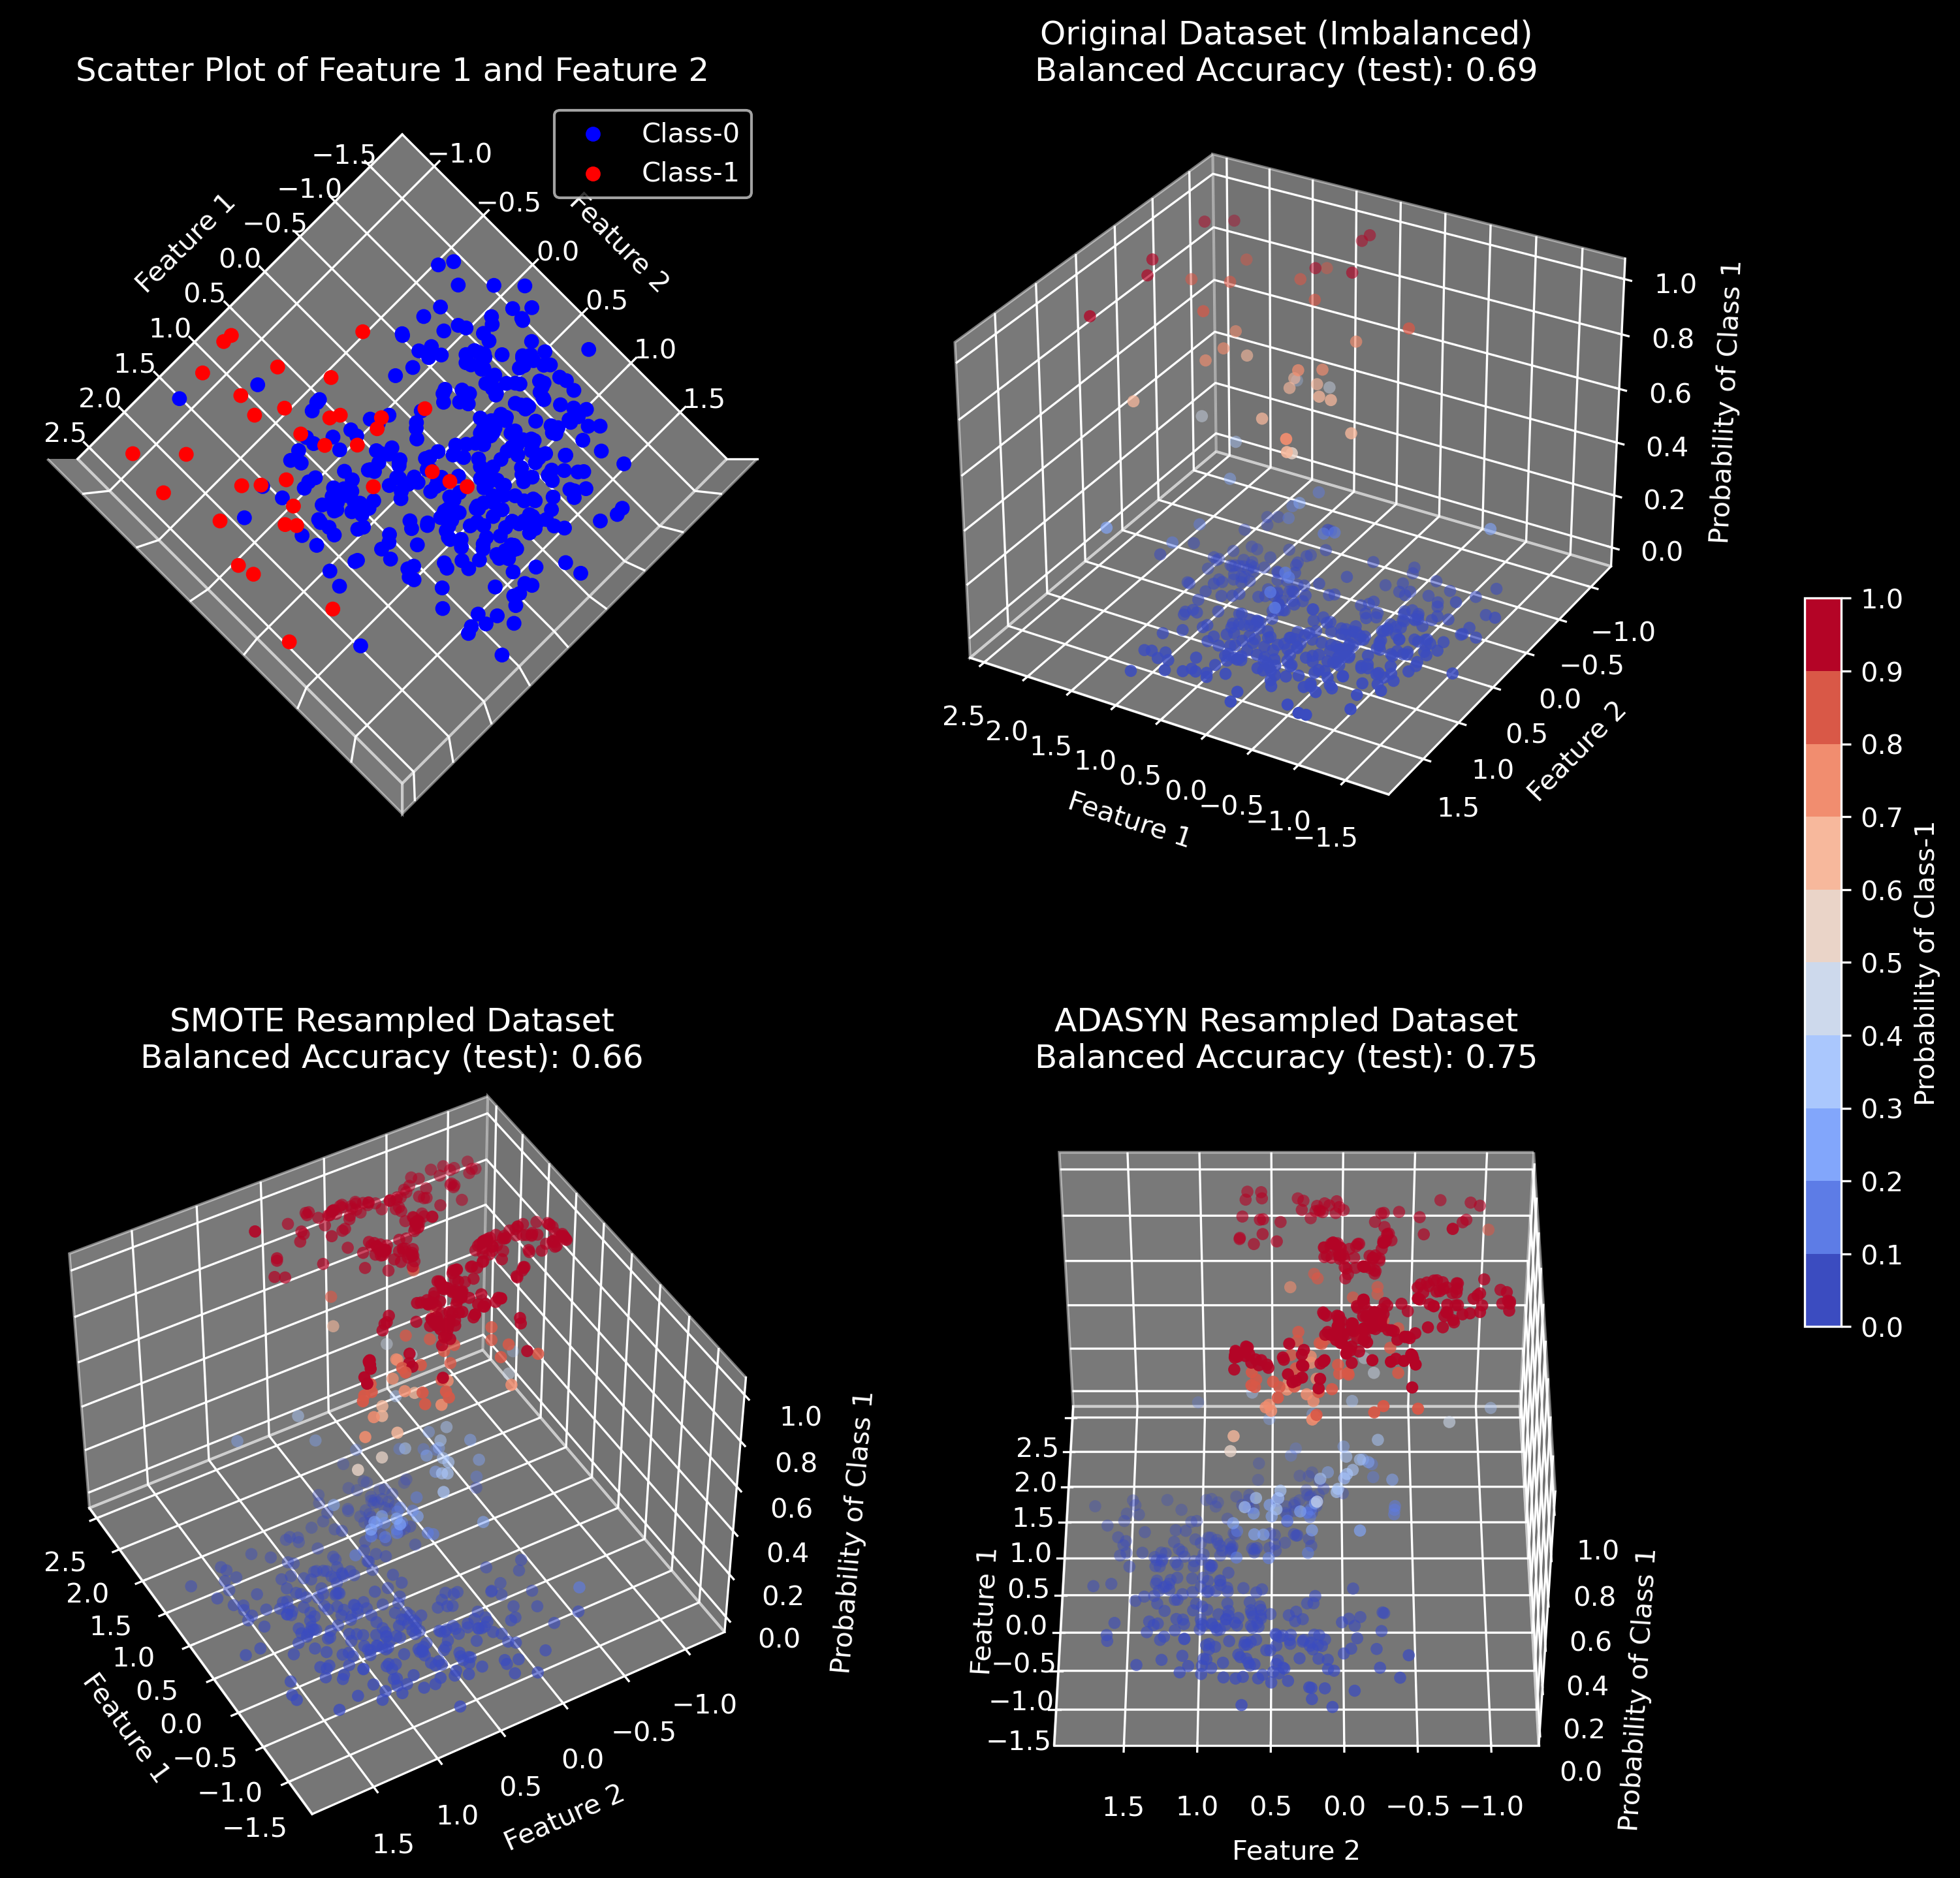

In [2]:
def plot_points_with_probabilities(
    X_train, y_train, X_test, y_test, 
    ax, resampler=None, title=None, elev=90, azim=45):
    if resampler:
        X_train, y_train = (
            resampler.fit_resample(X_train, y_train)
        )
    
    model = RandomForestClassifier(random_state=47)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    balanced_acc = (
        balanced_accuracy_score(y_test, y_pred)
    )

    prob_class_1 = model.predict_proba(X_train)[:, 1]

    cmap = ListedColormap(
        plt.cm.coolwarm(np.linspace(0, 1, 10))
    )

    scatter = ax.scatter(
        X_train[:, 0], X_train[:, 1], prob_class_1, 
        c=prob_class_1, cmap=cmap, edgecolor='none', 
        s=20
    )

    ax.set_title(
        f"{title}\nBalanced Accuracy (test): {balanced_acc:.2f}"
    )
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("Probability of Class 1")
    ax.view_init(elev=elev, azim=azim)

    return balanced_acc, scatter, cmap

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 12), 
    subplot_kw={'projection': '3d'}, dpi=300
)

ax1 = axes[0, 0]
scatter_class_0 = ax1.scatter(
    X_train[y_train == 0, 0], 
    X_train[y_train == 0, 1], c='blue', 
    label='Class-0', s=20
)
scatter_class_1 = ax1.scatter(
    X_train[y_train == 1, 0], 
    X_train[y_train == 1, 1], 
    c='red', label='Class-1', s=20
)
ax1.set_title("Scatter Plot of Feature 1 and Feature 2")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.view_init(elev=90, azim=45)
ax1.set_zticks([])
ax1.set_zticklabels([])

ax1.legend()

ax2 = axes[0, 1]
balanced_acc_original, scatter_original, cmap_original = plot_points_with_probabilities(
    X_train, y_train, X_test, y_test, ax2, title="Original Dataset (Imbalanced)", elev=30, azim=120
)

ax3 = axes[1, 0]
smote = SMOTE(random_state=47)
balanced_acc_smote, scatter_smote, cmap_smote = plot_points_with_probabilities(
    X_train, y_train, X_test, y_test, ax3, resampler=smote, title="SMOTE Resampled Dataset", elev=45, azim=150
)

ax4 = axes[1, 1]
adasyn = ADASYN(random_state=47)
balanced_acc_adasyn, scatter_adasyn, cmap_adasyn = plot_points_with_probabilities(
    X_train, y_train, X_test, y_test, ax4, resampler=adasyn, title="ADASYN Resampled Dataset", elev=45, azim=180
)

def update_view(frame):
    for ax in axes.ravel():
        ax.view_init(elev=30, azim=frame)
    return [scatter_original, scatter_smote, scatter_adasyn]

cbar = fig.colorbar(scatter_adasyn, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.08, cmap=cmap_original)
cbar.set_label('Probability of Class-1')
cbar.set_ticks([i / 10 for i in range(11)])

# ani = FuncAnimation(fig, update_view, frames=np.arange(0, 360, 2), interval=50)
# writer = PillowWriter(fps=25)
# ani.save('3d_rotation_animation.gif', writer=writer)

plt.show()

### **Synthetic Minority Over-sampling Technique (SMOTE):**

- **$x_{syn}$**: A synthetic sample generated to balance the class distribution.
- **$x_i$**: An instance from the minority class.
- **$x_{i_{NN}}$**: A nearest neighbor of the minority instance $x_i$, selected from the minority class. The number of neighbors is typically specified as $k$.
- **$\lambda$**: A random scaling factor between 0 and 1. It controls how much of the difference between $x_i$ and $x_{i_{NN}}$ is added to $x_i$ to create $x_{syn}$. It introduces variability in the synthetic samples.
  - **Formula**:  
    $$x_{syn} = x_i + \lambda \cdot (x_{i_{NN}} - x_i)$$
  - This means $x_{syn}$ is a point somewhere along the line between $x_i$ and $x_{i_{NN}}$, with $\lambda$ determining the exact position.

### **Adaptive Synthetic Sampling (ADASYN):**

- **$\delta_i$**: The difficulty of the minority instance $x_i$ in being classified correctly. It is calculated as the ratio of majority class neighbors to the total number of neighbors $k$ for $x_i$. Higher $\delta_i$ means the instance is harder to classify, typically close to the decision boundary.
  - **Formula**:  
    $$\delta_i = \frac{\text{Majority Neighbors}}{k}$$
  - If most neighbors of $x_i$ belong to the majority class, $\delta_i$ will be high, indicating it's difficult for a classifier to correctly classify $x_i$.
  
- **$N_{syn}$**: The number of synthetic samples generated for $x_i$. This is based on the difficulty $\delta_i$ of the instance, where instances with higher difficulty get more synthetic samples.
  - **Formula**:  
    $$N_{syn} = \lceil \delta_i \cdot k \rceil$$
  - The product of $\delta_i$ and $k$ determines how many synthetic samples are generated, and the ceiling function $\lceil \cdot \rceil$ ensures the number is an integer.

- **$x_{syn}$**: A synthetic sample created for $x_i$ in the same way as in SMOTE, with the same formula:
  $$x_{syn} = x_i + \lambda \cdot (x_{i_{NN}} - x_i)$$
  - The difference is that in ADASYN, more synthetic samples are generated for instances with a higher $\delta_i$, which are typically harder to classify.
